In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import warnings
import plotly.express as px
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('wine.csv', index_col=0)

In [3]:
def summarize(df):
    print("Dataset's shape:)", df.shape)
    print("Summary of dataset:")
    return df.info()
summarize(df)

Dataset's shape:) (3466, 28)
Summary of dataset:
<class 'pandas.core.frame.DataFrame'>
Index: 3466 entries, https://resources.vino.com/data/offertaFileFile/offertaFileFile-249057.jpg to https://resources.vino.com/data/offertaFileFile/offertaFileFile-254786.jpg
Data columns (total 28 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Price                     3466 non-null   object 
 1   Vino type                 3466 non-null   object 
 2   Ageing in barrel          3334 non-null   object 
 3   Body                      3463 non-null   object 
 4   Ideal with                3466 non-null   object 
 5   Aroma                     3466 non-null   object 
 6   Description               3466 non-null   object 
 7   full name                 3466 non-null   object 
 8   appellation               3466 non-null   object 
 9   vintage                   3466 non-null   float64
 10  country                   3466 non-null  

In [4]:
def aroma_filter(ser):
    if len(ser) > 8 or ser in ['France', 'Scotland', 'England', 'Italy', 'Peru', 'Haiti', 'Brazil', 'Barbados', 'Mexico', 'Russia', 'Poland', 'Sweden', 'Malty', 'Hoppy' '0']:
        return None
    else:
        return ser

In [5]:
def data_cleaning(df=df):
    df.drop_duplicates(inplace=True)
    filter = {'\n': '', 'None': np.NAN, '%': '', '℃': '', '()': '', ',': '.'}
    df.replace(filter, regex=True, inplace=True)
    df['Price'].replace(to_replace='€', value='', regex=True, inplace=True)
    df['Price'] = df['Price']
    df.drop(['aromas', 'temperature', 'Ageing in barrel', 'Body', 'appellation', 'Sulfites', 'dosage ', 'Producer', 'Municipality of Producer', 'ageing',
       'taste', 'ingredients', 'Allergens', 'Beer type', 'fruity', 'set'], axis=1, inplace=True)
  
    df['Price'] = df['Price'].astype(float)
    df['vintage'] = df['vintage'].astype(int).replace(0, None)
    df['format'] = df['format'].replace({'L': ''}, regex=True).astype(float)
    df['alcohol content'] = df['alcohol content'].astype(float)
    df['Aroma'] = df['Aroma'].apply(aroma_filter).replace('0', None)
    df.rename(str.capitalize, axis='columns', inplace=True)
    df.dropna(inplace=True)

    return df.reset_index()

df = data_cleaning()
df.head(10)

,Vino photo,Price,Vino type,Ideal with,Aroma,Description,Full name,Vintage,Country,Region,Grape,Format,Alcohol content
0,https://resources.vino.com/data/offertaFileFil...,35.6,Red,Aged cheeses. Red meat. Game,Fruity,Amarone Costasera Masi hails from the vineyard...,Amarone della Valpolicella Classico DOCG Costa...,2018,Italy,Veneto,Corvina Veronese. Molinara. Rondinella,0.75,15.0
1,https://resources.vino.com/data/offertaFileFil...,17.0,Red,Roasts. Grilled red meat. Red meat,Fruity,Biondi Santi's Toscana Rosso Sassoalloro was ...,Toscana IGT Sassoalloro 2022 Jacopo Biondi Santi,2022,Italy,Tuscany,Sangiovese,0.75,14.0
2,https://resources.vino.com/data/offertaFileFil...,30.8,Red,Game. Roasts. Red meat. Aged cheeses,Fruity,The Brunello di Montalcino of Fattoria dei Ba...,Brunello di Montalcino DOCG 2018 Fattoria dei ...,2018,Italy,Tuscany,Sangiovese 100,0.75,14.5
3,https://resources.vino.com/data/offertaFileFil...,13.5,Red,Red meat. Aged cheeses. Game,Fruity,Pinot Noir from Blumenfeld is a typical red wi...,Südtirol - Alto Adige DOC Pinot Nero 2022 Blum...,2022,Italy,South Tyrol,Pinot Noir 100,0.75,13.0
4,https://resources.vino.com/data/offertaFileFil...,7.9,Red,Red meat. Roasts. First courses,Fruity,Nero d'Avola Inessa is produced with 100 Nero ...,Sicilia DOC Nero d'Avola 2022 Inessa,2022,Italy,Sicily,Nero d'Avola 100,0.75,14.5
5,https://resources.vino.com/data/offertaFileFil...,9.9,Red,Aged cheeses. Roasts. Grilled red meat,Fruity,The Toscana IGT La Lallera pays homage to the ...,Toscana IGT La Lallera 2020 Borgo San Frediano,2020,Italy,Tuscany,Cabernet Sauvignon. Merlot. Petit Verdot,0.75,14.0
6,https://resources.vino.com/data/offertaFileFil...,24.9,Red,First courses. Stews. Meat ragout. Grilled red...,Spicy,Antinori is one of the most illustrious and f...,Bolgheri DOC Guado al Tasso Il Bruciato 2022 M...,2022,Italy,Tuscany,Cabernet Sauvignon 65. Merlot 20. Syrah 15,0.75,14.0
7,https://resources.vino.com/data/offertaFileFil...,8.9,Red,Aged cheeses. Grilled red meat. First courses,Fruity,A riot of colours that are enhanced in a colo...,Terre Siciliane IGT Syrah con Leggero Appassim...,2021,Italy,Sicily,Syrah 100,0.75,14.0
8,https://resources.vino.com/data/offertaFileFil...,9.5,Red,Meat ragout. First courses. Pizza,Fruity,A wine that comes from 100 Barbera grapes. in ...,Barbera d'Alba DOC 2021 Sabaudo,2021,Italy,Piedmont,Barbera 100,0.75,14.5
9,https://resources.vino.com/data/offertaFileFil...,16.9,Red,Roasts. Aged cheeses. First courses. Stews,Floral,The Bolgheri Rosso Campo al Faro was born in t...,Bolgheri DOC Rosso 2021 Campo al Faro,2021,Italy,Tuscany,Cabernet Franc. Cabernet Sauvignon. Merlot,0.75,14.0


# Visualising

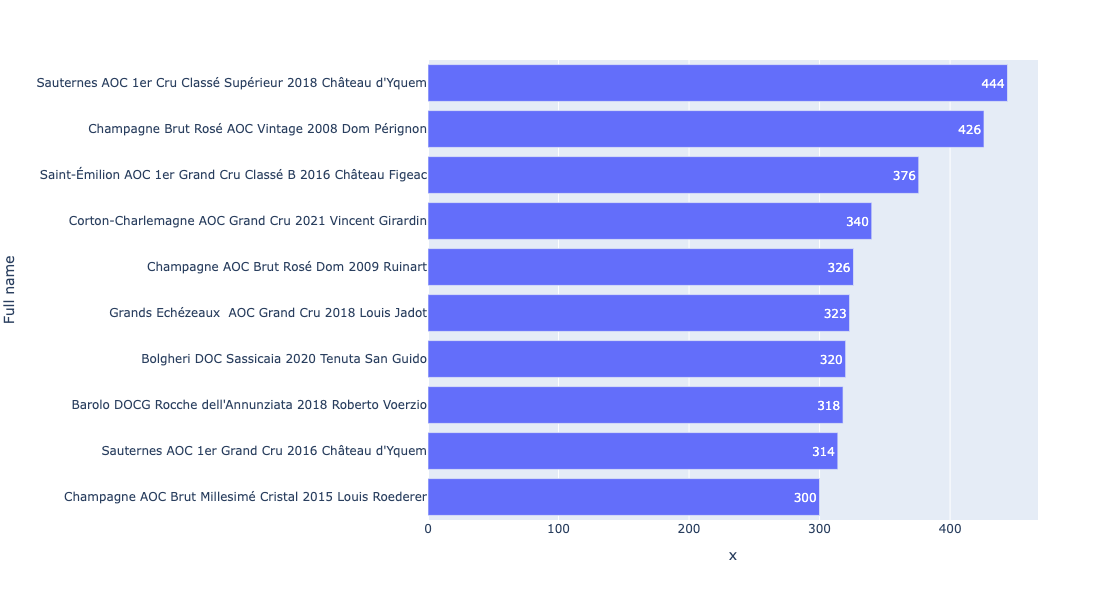

In [15]:
def most_exp(df=df, n=10):
    '''The most expensive wines'''
    df2 = df.groupby('Full name')['Price'].max().sort_values(ascending=False).head(n).sort_values()
    fig = px.bar(df2, y=df2.index, x=df2.values, text_auto=True)
    fig.update_layout(width=600, height=600).show()
most_exp()

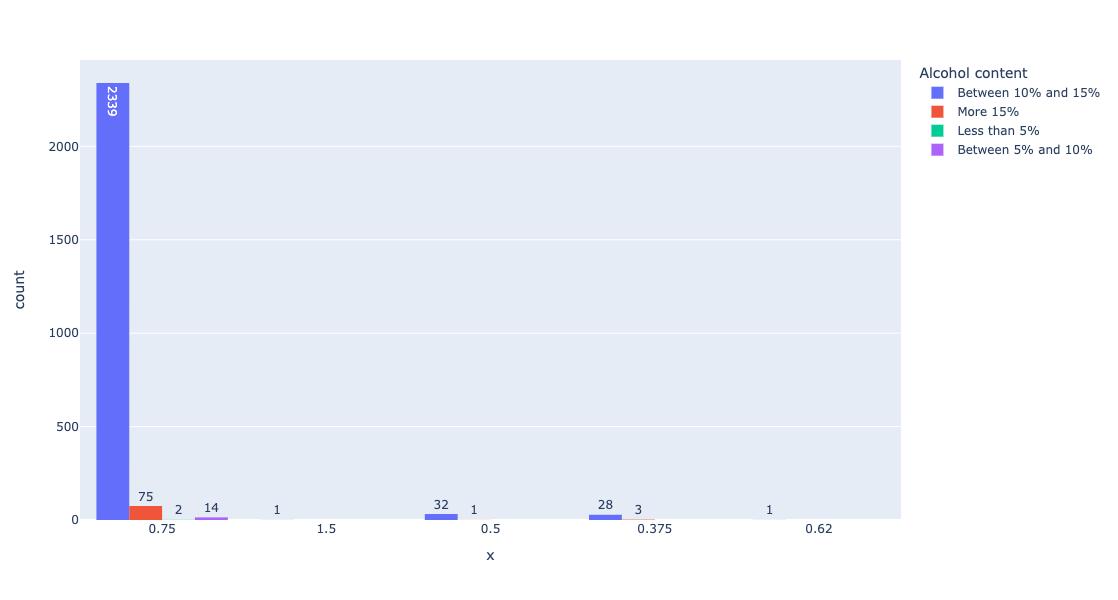

In [9]:
bins = [0, 5, 10, 15, float('inf')]
labels = ['Less than 5%', 'Between 5% and 10%', 'Between 10% and 15%', 'More 15%']
df2 = df[['Format', 'Alcohol content']]
df2['Alcohol content'] = pd.cut(df['Alcohol content'], bins=bins, labels=labels)

fig = px.histogram(df2, x=df2['Format'].astype(str), color='Alcohol content', barmode='group', text_auto=True)
fig.update_layout(width=600, height=600).show()

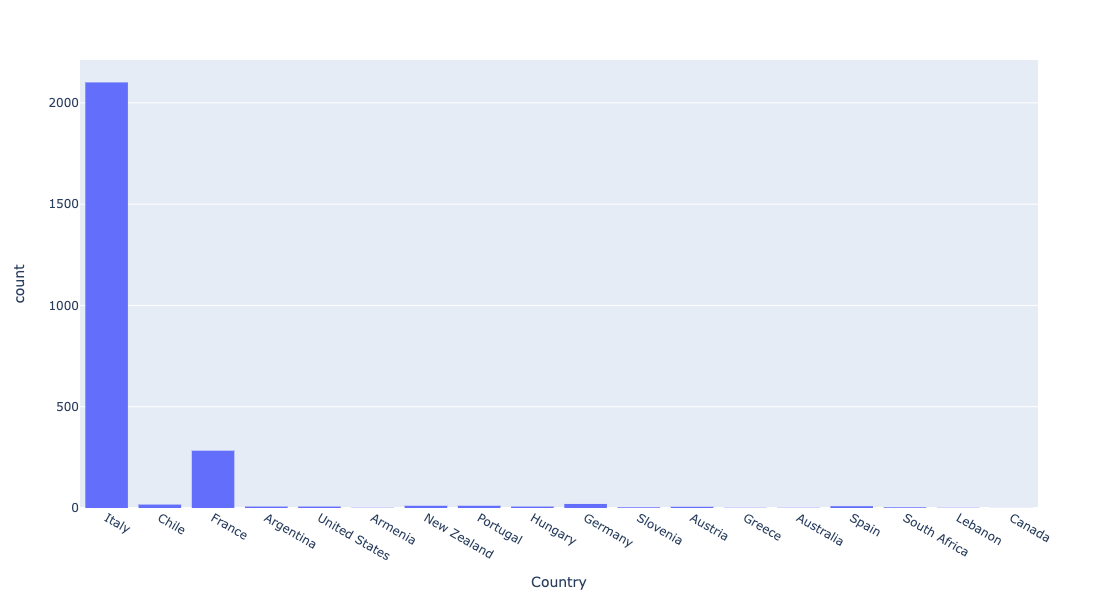

In [10]:
fig = px.histogram(df, x='Country')
fig.update_layout(width=600, height=600).show()

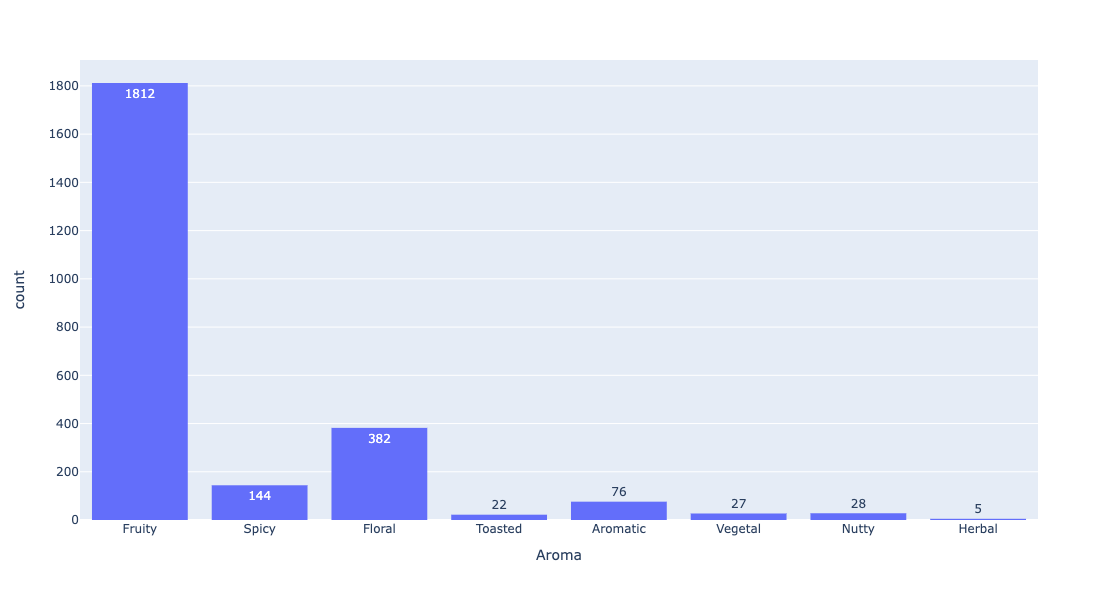

In [12]:
def count_aroma(df=df):
    fig = px.histogram(df, x='Aroma', text_auto=True)
    fig.update_layout(width=600, height=600).show()
count_aroma()

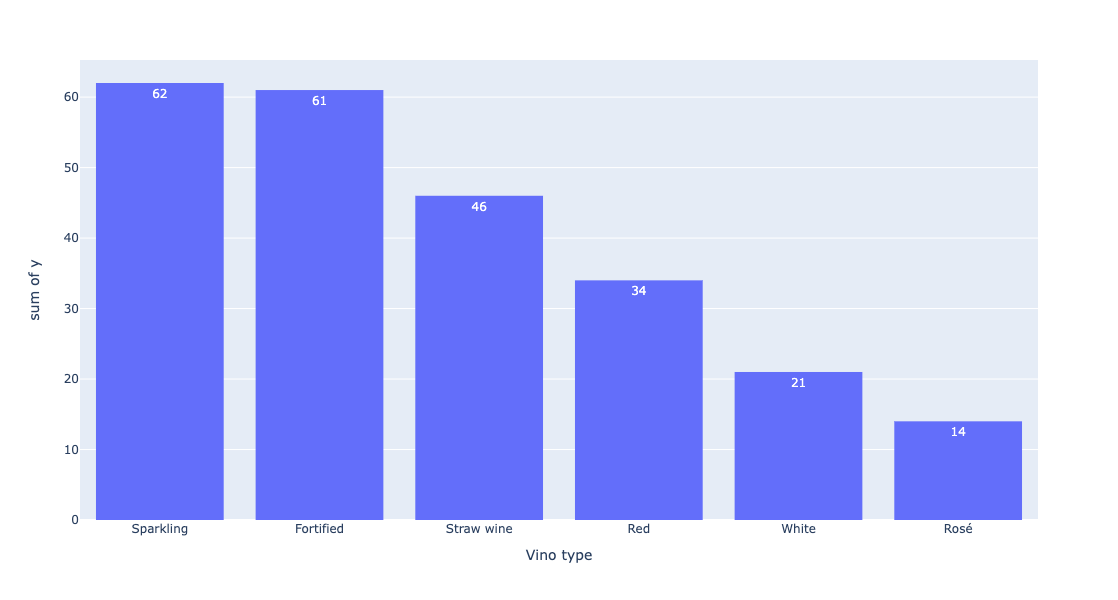

In [13]:
def exp_wine_type(df=df):
    df2 = df.groupby('Vino type')['Price'].mean().sort_values(ascending=False)
    fig = px.histogram(df2, x=df2.index, y=df2.values.round(), text_auto=True)
    fig.update_layout(width=600, height=600).show()
exp_wine_type()

# Preprossesing

In [6]:
df['All_futures'] = df['Ideal with'] + ' ' + df['Aroma'] + ' ' + df['Country'] + ' ' + df['Grape'] + ' ' + df['Vino type']
df['All_futures'] = df['All_futures'].str.lower()

In [7]:
df

,Vino photo,Price,Vino type,Ideal with,Aroma,Description,Full name,Vintage,Country,Region,Grape,Format,Alcohol content,All_futures
0,https://resources.vino.com/data/offertaFileFil...,35.6,Red,Aged cheeses. Red meat. Game,Fruity,Amarone Costasera Masi hails from the vineyard...,Amarone della Valpolicella Classico DOCG Costa...,2018,Italy,Veneto,Corvina Veronese. Molinara. Rondinella,0.75,15.0,aged cheeses. red meat. game fruity italy corv...
1,https://resources.vino.com/data/offertaFileFil...,17.0,Red,Roasts. Grilled red meat. Red meat,Fruity,Biondi Santi's Toscana Rosso Sassoalloro was ...,Toscana IGT Sassoalloro 2022 Jacopo Biondi Santi,2022,Italy,Tuscany,Sangiovese,0.75,14.0,roasts. grilled red meat. red meat fruity ital...
2,https://resources.vino.com/data/offertaFileFil...,30.8,Red,Game. Roasts. Red meat. Aged cheeses,Fruity,The Brunello di Montalcino of Fattoria dei Ba...,Brunello di Montalcino DOCG 2018 Fattoria dei ...,2018,Italy,Tuscany,Sangiovese 100,0.75,14.5,game. roasts. red meat. aged cheeses fruity it...
3,https://resources.vino.com/data/offertaFileFil...,13.5,Red,Red meat. Aged cheeses. Game,Fruity,Pinot Noir from Blumenfeld is a typical red wi...,Südtirol - Alto Adige DOC Pinot Nero 2022 Blum...,2022,Italy,South Tyrol,Pinot Noir 100,0.75,13.0,red meat. aged cheeses. game fruity italy pino...
4,https://resources.vino.com/data/offertaFileFil...,7.9,Red,Red meat. Roasts. First courses,Fruity,Nero d'Avola Inessa is produced with 100 Nero ...,Sicilia DOC Nero d'Avola 2022 Inessa,2022,Italy,Sicily,Nero d'Avola 100,0.75,14.5,red meat. roasts. first courses fruity italy n...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2491,https://resources.vino.com/data/offertaFileFil...,28.5,Red,Mushrooms. Game birds. Aged cheeses. Stews,Spicy,The Barolo Paesi Tuoi of the Vite Colte compa...,Barolo DOCG Paesi Tuoi 2019 Vite Colte,2019,Italy,Piedmont,Nebbiolo 100,0.75,14.0,mushrooms. game birds. aged cheeses. stews spi...
2492,https://resources.vino.com/data/offertaFileFil...,30.9,Sparkling,Aperitifs. Fish. Risotto,Floral,The Franciacorta Brut Satèn by Castello Bonomi...,Franciacorta Brut Satèn DOCG Millesimato 2019 ...,2019,Italy,Lombardy,Chardonnay 100,0.75,12.5,aperitifs. fish. risotto floral italy chardonn...
2493,https://resources.vino.com/data/offertaFileFil...,24.3,White,Soups. Aperitifs. Vegetables,Fruity,The Quintessenz line includes the excellent pr...,Südtirol - Alto Adige DOC Quintessenz Sauvigno...,2021,Italy,South Tyrol,Sauvignon Blanc 100,0.75,13.5,soups. aperitifs. vegetables fruity italy sauv...
2494,https://resources.vino.com/data/offertaFileFil...,11.3,White,Aperitifs. Raw fish. Cold cuts and cured meats...,Fruity,Friulano Sirch is produced in Friuli Venezia G...,Friuli Colli Orientali DOC Friulano 2022 Sirch,2022,Italy,Friuli Venezia Giulia,Friulano 100,0.75,13.5,aperitifs. raw fish. cold cuts and cured meats...


In [8]:
tfidf_model = TfidfVectorizer()
tfidf_matrix = tfidf_model.fit_transform(df['All_futures'])

In [9]:
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
cosine_sim

array([[1.        , 0.31728135, 0.42549593, ..., 0.03511743, 0.04651779,
        0.09368691],
       [0.31728135, 1.        , 0.74867528, ..., 0.04588573, 0.08873675,
        0.19157045],
       [0.42549593, 0.74867528, 1.        , ..., 0.09530091, 0.09990645,
        0.17539311],
       ...,
       [0.03511743, 0.04588573, 0.09530091, ..., 1.        , 0.2066244 ,
        0.14057424],
       [0.04651779, 0.08873675, 0.09990645, ..., 0.2066244 , 1.        ,
        0.22273233],
       [0.09368691, 0.19157045, 0.17539311, ..., 0.14057424, 0.22273233,
        1.        ]])

In [10]:
all = list(enumerate(cosine_sim[444]))
all_sorted = sorted(all, key=lambda x: x[1], reverse=True)

In [11]:
def get_recommendations(input_data, cosine_sim=cosine_sim, n=5):
    '''gives recommendation according input data'''
    input_text = " ".join(input_data.values())
    input_vector = tfidf_model.transform([input_text])
    sim_vector = list(cosine_similarity(input_vector, tfidf_matrix)[0])

    sorted_vector = sorted([[i, sim_vector[i]] for i in range(len(sim_vector))], key=lambda x: x[1], reverse=True)
    top_idxs = [sorted_vector[i][0] for i in range(n)]
    df3 = df.iloc[top_idxs][['Vino type', 'Aroma', 'Ideal with', 'Country', 'Grape', 'Vino photo']]
    df3['Similarity %'] = [int(i[1] * 100) for i in sorted_vector[: n]]
    df3.index = range(1, len(df3) + 1)
    df3.index = df3.index.rename('id')
    return df3[df3['Similarity %'] >= 60]

In [13]:
def offer():
    custom_input = dict()
    print('Hello and welcome to our online wine market. \nWhat kind of wine are you searching for? \nPlease answer these questions.')
    custom_input['Aroma'] = input('How to have a wine aroma (Fruity)?\n').lower()
    custom_input['Ideal with'] = input('What food do you want to eat wine with (Red meat, Aged cheeses)?\n').lower()
    custom_input['Country'] = input('Which country\'s wine do you want (Italy)?: ').lower()
    custom_input['Grape'] = input('What type of grapes do you want wine made from (Sangiovese)?\n').lower()
    custom_input['Vino type'] = input('hat type of wine you want (red)?')
    recommendations = get_recommendations(custom_input)
    if type(recommendations) != str and recommendations.shape[0] > 0:
        print("Here recommended wines that you searched for:")
        return recommendations
    else:
        return 'Sorry, wine that you have searched, not found. Please try again.'
recommendation = offer()
recommendation.drop('Vino photo', axis=1)

Hello and welcome to our online wine market. 
What kind of wine are you searching for? 
Please answer these questions.
Here recommended wines that you searched for:


,Vino type,Aroma,Ideal with,Country,Grape,Similarity %
id,,,,,,
1,Red,Fruity,Red meat,Italy,Sangiovese 100,95
2,Red,Fruity,Red meat,Italy,Sangiovese 100,95
3,Red,Fruity,Game. Red meat,Italy,Sangiovese 100,87
4,Red,Fruity,Red meat. Game,Italy,Sangiovese 100,87
5,Red,Fruity,Roasts. Grilled red meat. Red meat,Italy,Sangiovese,85


In [18]:
def display_wine(index, df=df):
    photo_link = df.iloc[index]['Vino photo']
    description = df.iloc[index]['Description']
    price = f"{df.iloc[index]['Price']}€"
    name = df.iloc[index]['Full name']
    
    response = requests.get(photo_link)
    img = Image.open(BytesIO(response.content))

    fig, ax = plt.subplots(2, 1, figsize=(8, 10))

    ax[0].imshow(img)
    ax[0].axis('off')

    ax[1].text(0.5, 0.4, f"Name: {name}\nPrice: {price}\nDescription:\n{description}", 
               color='black', fontsize=12, ha='center', va='center', wrap=True, multialignment='left')
    ax[1].axis('off')
    
    return plt.show()


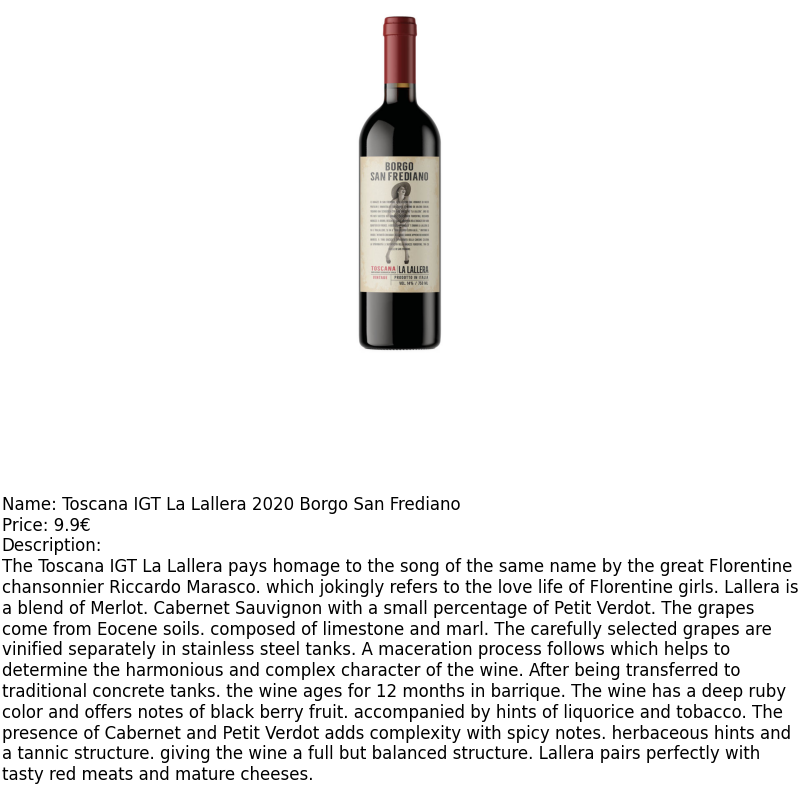

In [19]:
def liked_wine(df):
    selected_wine_idx = input('Please choose the wine id that you liked: ')
    try:
        selected_wine_idx = int(selected_wine_idx)
        if selected_wine_idx in df.index:
            display_wine(selected_wine_idx)
        else:
         print("Wrong Input!!! Try to run again.")
    except:
        print("Wrong Input!!! Your input should be a number. Try to run again.")
liked_wine(recommendation)